In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import percentileofscore, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
from rasterio import features
from affine import Affine
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl import geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



/dartfs-hpc/rc/home/0/f004260/.conda/envs/arg/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def calc_grid_cell_areas(ds, lat_name="lat", lon_name="lon", r_earth=6.371e6):
    """
    Calculate the area (in km^2) of DataSet or DataArray grid cells, using the following formula:
    A = r^2 * (lon1 - lon0) * (sin(lat1) - sin(lat0))
    where r is the radius of the earth, lon1 and lon0 are the max and min bounds of the grid cell along the x-axis, lat1 and lat0
    along the y-axis.
    Note: currently assumes coordinates refer to center of grid cells (but not necessarily that they're evenly spaced)
    """
    def get_bounds(coords_1d):
        """
        Calculates boundaries of grid cells in one dimension
        """
        diffs = np.diff(coords_1d)
        diffs = np.insert(diffs, 0, diffs[0])
        diffs = np.append(diffs, diffs[-1])
        min_bounds = coords_1d - diffs[:-1] / 2
        max_bounds = coords_1d + diffs[1:] / 2
        return np.array([min_bounds, max_bounds]).transpose()
    # get boundaries of grid cells, convert to radians
    lat_bounds = get_bounds(ds[lat_name])
    lat_bounds_rad = np.deg2rad(lat_bounds)
    lon_bounds = get_bounds(ds[lon_name])
    lon_bounds_rad = np.deg2rad(lon_bounds)
    # get widths and heights (in radians) of grid cells
    y_lens = np.sin(lat_bounds_rad[:, 1]) - np.sin(lat_bounds_rad[:, 0])
    x_lens = lon_bounds_rad[:, 1] - lon_bounds_rad[:, 0]
    # calculate areas in km^2 given widths and heights in radians
    areas = (r_earth ** 2) * np.outer(y_lens, x_lens)
    area_da = xr.DataArray(areas, coords=[ds[lat_name],ds[lon_name]], dims=["lat", "lon"])
    return area_da

In [3]:
def get_wy(dates):
    wys = []
    for date in dates:
        if date.month >= 10:
            wys.append(date.year+1)
        else:
            wys.append(date.year)
    return wys
    
def get_dowy(dates):
    days = []
    for date in dates:
        if date.month >= 10:
            dowy = date.dayofyear - pd.to_datetime(f"{date.year}-10-01").dayofyear + 1
        else: 
            dowy = date.dayofyear + 92
        if date.year % 4 == 0 and dowy>=92+61:
            dowy = dowy -1
        days.append(dowy)
    return days

In [4]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))
    

# uaz = uaz.assign(basin=(("lat","lon"),))

In [5]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [6]:
PLOT_BASIN = "COLUMBIA"
PLOT_YEAR = 2015

In [7]:
root_dir = "/dartfs-hpc/rc/lab/C/CMIG"
data_dir = os.path.join(root_dir, "agottlieb", 'git_repos',"snow_drought", "data")
fig_dir = os.path.join(root_dir, "agottlieb", 'git_repos',"snow_drought", "figures")

In [8]:
snotel_dir = os.path.join(data_dir,'basin','SNOTEL')
snotel_files = [os.path.join(snotel_dir,f) for f in os.listdir(snotel_dir)]
snotel_files.sort()

In [15]:
# load basin boundaries
grdc_basins = gpd.read_file(os.path.join(data_dir, "boundaries", "grdc_basins"), layer="mrb_basins")
basin_ids = {k: i for i, k in zip(grdc_basins.index,grdc_basins.RIVER_BASI)}

In [16]:
# load SNOTEL basin-average data
snotel_basin = xr.open_mfdataset(snotel_files)
snotel_basin = snotel_basin.sel(time=snotel_basin['time'][~((snotel_basin['time.month']==2)&(snotel_basin['time.day']==29))])
snotel_basin = snotel_basin.assign(dowy=(('time'),get_dowy(pd.to_datetime(snotel_basin['time'].values))))
snotel_basin = snotel_basin.assign(wy=(('time'),get_wy(pd.to_datetime(snotel_basin['time'].values))))

# subset out basin of interest
plot_basin_data = snotel_basin.sel(basin=basin_ids[PLOT_BASIN]).load()

# calculate standardized SWEI, group into bins
plot_basin_data["SWEI"] = plot_basin_data["SWE"].rolling(time=90).sum().groupby("time.dayofyear").apply(lambda x: norm.ppf((x.rank("time")-0.44)/(x.count("time")+0.12)))
swei_thresh = [-np.inf, -2, -1.6, -1.3, -0.8, -0.5, 0.5, 0.8, 1.3, 1.6, 2, np.inf]
def swei_class(x):
    return pd.cut(x, bins=swei_thresh, labels=np.arange(-5,6)) # -5 = D4, 0=NN
plot_basin_data["SWEI_class"] = xr.apply_ufunc(swei_class, plot_basin_data["SWEI"])

# subset out year of interest
year_plot_data = plot_basin_data.sel(time=plot_basin_data["time"][plot_basin_data["wy"]==PLOT_YEAR])


In [17]:
# get climatology for each DOWY
plot_pct_clim = year_plot_data['SWE_pct_med'].values

plot_peak = plot_basin_data['SWE'].resample(time="AS-OCT").max() # get peak SWE
plot_apr1 = plot_basin_data['SWE'].sel(time=plot_basin_data["time"][(plot_basin_data["time.month"]==4) & (plot_basin_data["time.day"]==1)]) # get April 1 SWE

dps = plot_basin_data["SWE"].groupby(plot_basin_data["wy"]).apply(lambda x: x.idxmax()) # get date of peak SWE in each WY
dps.values = np.array(get_dowy(pd.to_datetime(dps.values))) # convert to datetime

In [18]:
# convert DataArrays to DataFrames
plot_basin_df = plot_basin_data.to_dataframe().reset_index()
plot_basin_clim_df = plot_basin_data.groupby(plot_basin_data["dowy"]).mean().to_dataframe().reset_index().set_index("dowy")
plot_apr1_df = plot_apr1.to_dataframe().reset_index()
plot_peak_df = plot_peak.to_dataframe().reset_index()


In [22]:
plot_basin_df

,time,SWE,SWE_pct_med,basin,dowy,wy,SWEI,SWEI_class
0,1980-10-01,0.082887,0.045960,485,1,1981,NaN,NaN
1,1980-10-02,0.145817,0.076991,485,2,1981,NaN,NaN
2,1980-10-03,0.127544,0.058886,485,3,1981,NaN,NaN
3,1980-10-04,0.133221,0.048505,485,4,1981,NaN,NaN
4,1980-10-05,0.102017,0.031718,485,5,1981,NaN,NaN
...,...,...,...,...,...,...,...,...
14595,2020-09-26,0.075715,0.058039,485,361,2020,-0.093855,0.0
14596,2020-09-27,0.124825,0.092826,485,362,2020,-0.156836,0.0
14597,2020-09-28,0.063194,0.043821,485,363,2020,-0.093855,0.0
14598,2020-09-29,0.046110,0.031033,485,364,2020,-0.350688,0.0


In [23]:
# generate heatmap for percentiles of different metrics
defs = ["SWE", "SWEI", "Apr 1 SWE", "Peak SWE", "Date of\nPeak SWE"]
heatmap_df = pd.DataFrame(index=defs,columns=plot_basin_data["time"].values)

# continuous measures 
for idx, row in plot_basin_df.iterrows():
    heatmap_df.at["SWE", row["time"]] = percentileofscore(plot_basin_df.loc[plot_basin_df.dowy==row.dowy, "SWE"], row["SWE"]) # peak SWE
heatmap_df.loc["SWEI"] = 100*norm.cdf(plot_basin_df["SWEI"].values) # convert SWEI back to percentile 

# yearly metrics
for wy in range(1981,2021):
    heatmap_df.loc["Apr 1 SWE", f"{wy-1}-10-01":f"{wy}-09-30"] = percentileofscore(plot_apr1.values, plot_apr1.sel(time=f"{wy}-04-01").values)
    heatmap_df.loc["Peak SWE", f"{wy-1}-10-01":f"{wy}-09-30"] = percentileofscore(plot_peak.values, plot_peak.sel(time=f"{wy-1}-10-01").values)
    heatmap_df.loc["Date of\nPeak SWE", f"{wy-1}-10-01":f"{wy}-09-30"] = percentileofscore(dps.values, dps.sel(wy=wy).values)
heatmap_df.columns.name=""
heatmap_df = heatmap_df.astype(float)
heatmap_df = heatmap_df.loc[:, "1980-10-01":"2020-09-30"]


In [25]:
# generate binary heatmap for when each other would identify a snow drought
author_defs = ["D19","H17","HM17","HA20","M19-Low","M19-Early"]
author_df = pd.DataFrame(index=author_defs,columns=plot_basin_data["time"].values)

# Hatchett and McEvory (2017): daily SWE below clim. median
for idx, row in plot_basin_df.iterrows():
    author_df.at["HM17", row["time"]] = (row["SWE"] / plot_basin_clim_df.loc[row.dowy, "SWE"]) < 1
    
# Huning and AghaKouchak (2020): SWEI < -0.8
author_df.loc["HA20"] = (plot_basin_df["SWEI"] < -0.8).values

# Harpold et al. (2017): sub-normal April 1 SWEfor idx, row in plot_apr1_df.iterrows():
for idx, row in plot_apr1_df.iterrows():
    author_df.loc["H17", f"{row.time.year-1}-10-01":f"{row.time.year}-09-30"] = (row["SWE"]/plot_apr1_df["SWE"].mean()) < 1

for idx, row in plot_peak_df.iterrows():
    yr = row.time.year
    # Marshall et al. (2019): peak SWE < 25th %ile
    author_df.loc["M19-Low", f"{yr}-10-01":f"{yr+1}-09-30"] = percentileofscore(plot_peak_df["SWE"],row["SWE"]) < 25
    # Dierauer et al. (2019): sub-normal peak SWE
    author_df.loc["D19", f"{yr}-10-01":f"{yr+1}-09-30"] = (row["SWE"] / plot_peak_df["SWE"].mean()) < 1
    
# Marshall et al. (2019): date of peak SWE < 25th %ile
for y in range(dps["wy"].min().values,dps["wy"].max().values):
    author_df.loc["M19-Early", f"{y-1}-10-01":f"{y}-09-30"] = percentileofscore(dps.values,dps.sel(wy=y).values) < 25
author_df.columns.name=""
author_df = author_df.astype(float)
author_df = author_df.loc[:,"1980-10-01":"2020-09-30"]

<ipython-input-25-0e0b3adecce4>:7: RuntimeWarning: invalid value encountered in double_scalars
  author_df.at["HM17", row["time"]] = (row["SWE"] / plot_basin_clim_df.loc[row.dowy, "SWE"]) < 1


Text(0.42, 0.4, 'c')

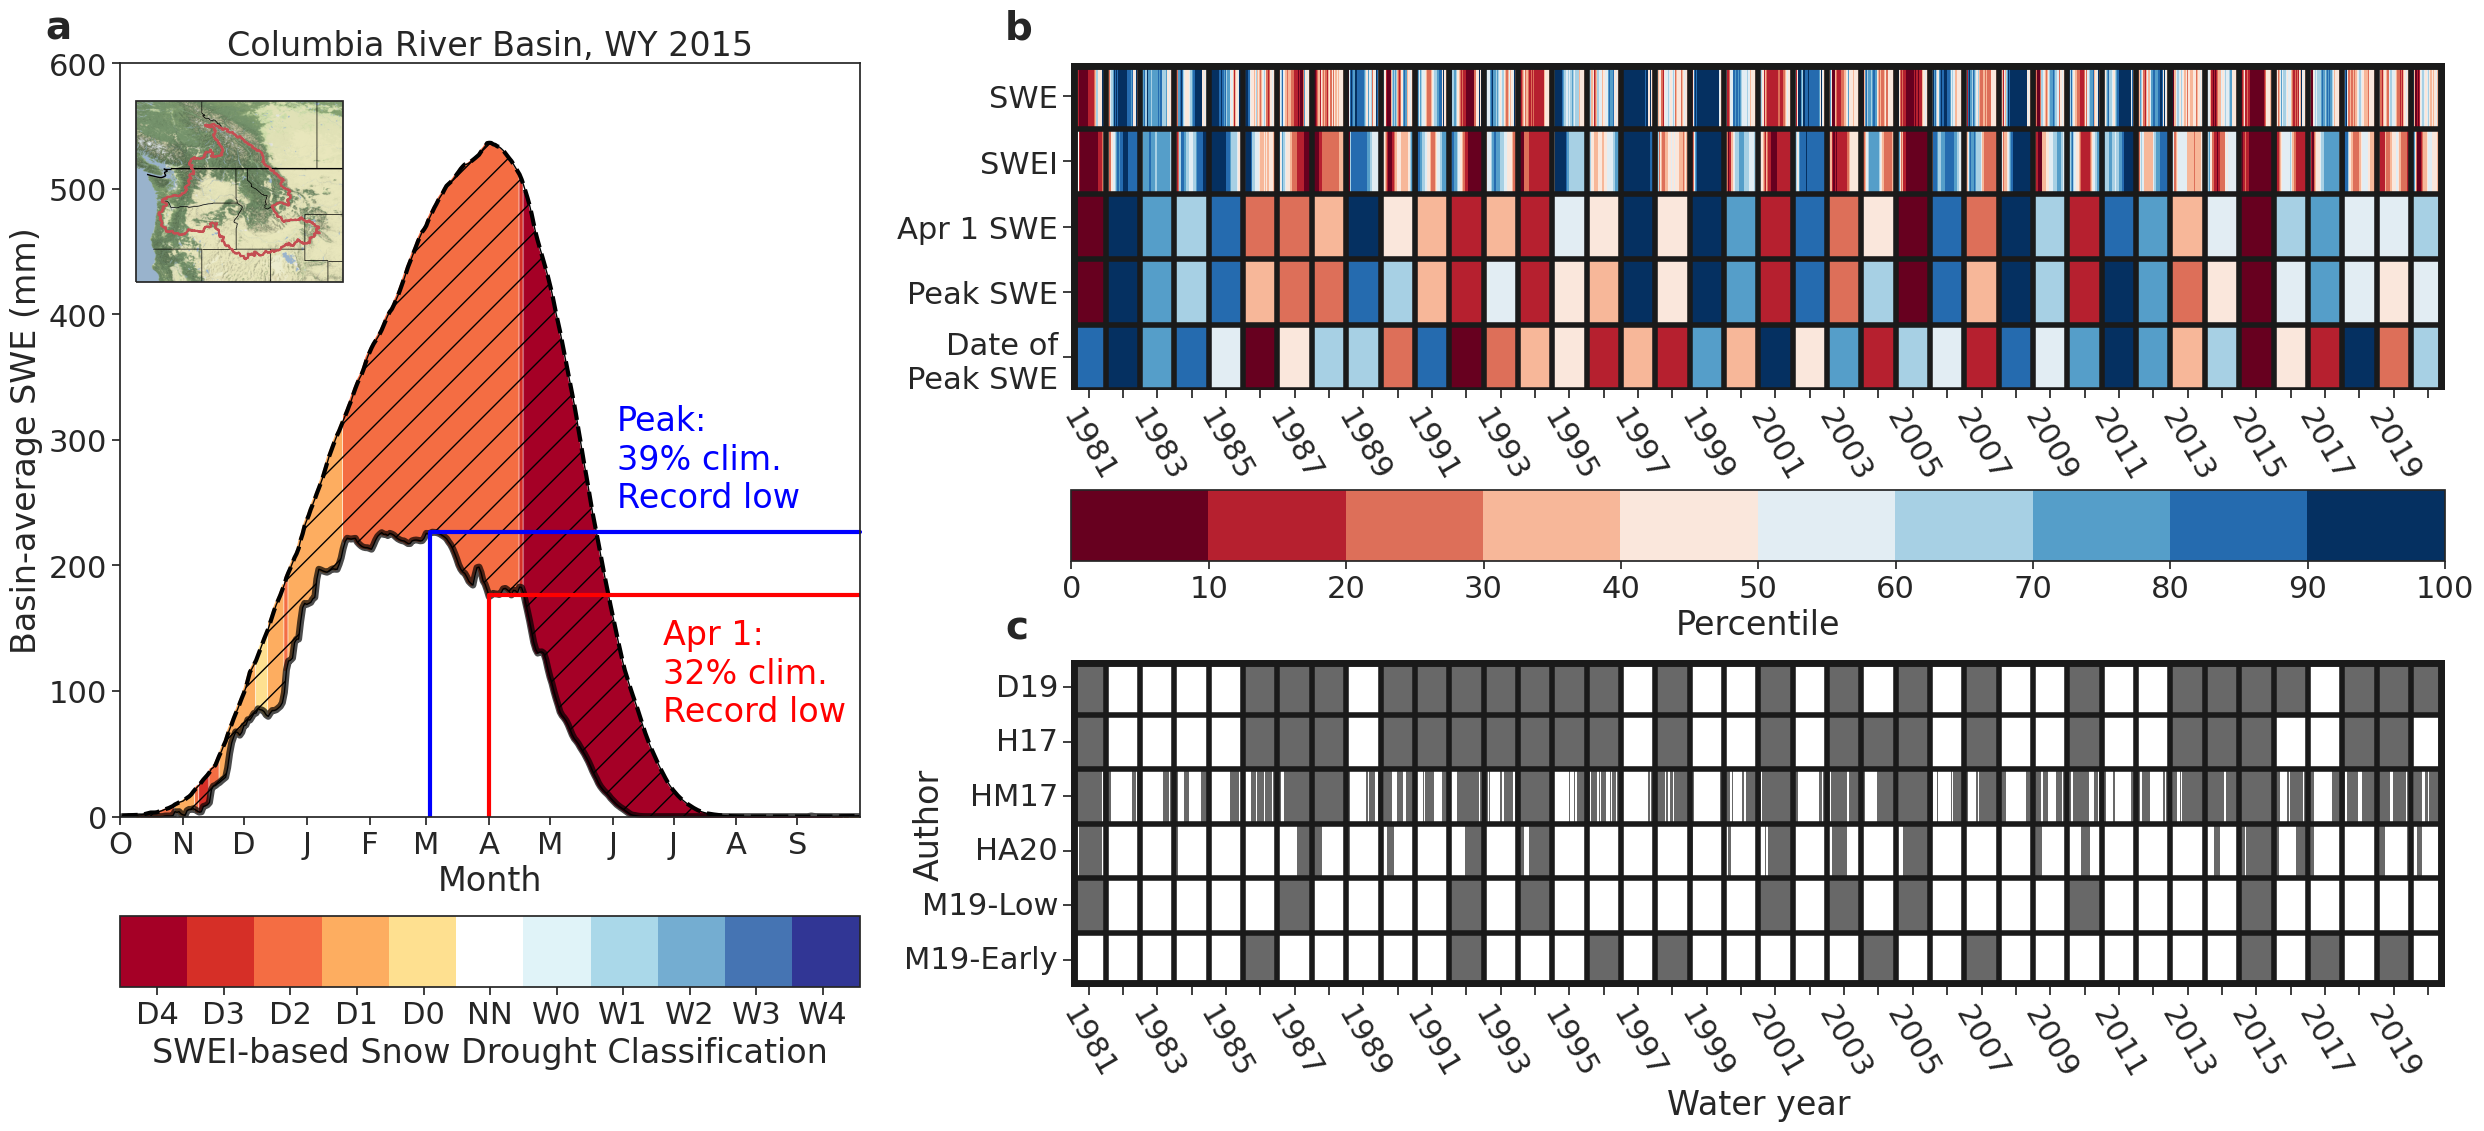

In [29]:
sns.set(font_scale=2,
        style="ticks")
from matplotlib import rcParams
rcParams.update({'figure.autolayout': False, "hatch.color": "black"})

fig = plt.figure(figsize=(30,12))
gs = gridspec.GridSpec(ncols=2, nrows=11, width_ratios=[3.5,6.5], figure=fig)

#################
### Figure 2a ###
#################

ax = plt.subplot(gs[:9,0])

# plot climatological SWE
sns.lineplot(x=plot_basin_clim_df.index, y=plot_basin_clim_df["SWE"].values, lw=3, color="black",legend=False, ax=ax)
for line in ax.lines:
    line.set_linestyle("--") # change linestyle
# plot WY 2015 SWE
sns.lineplot(x=year_plot_data['dowy'], y=year_plot_data["SWE"].values, alpha=0.7, lw=5, color="black",legend=False, ax=ax)
ax.set_ylim(0,600)
ax.set_xlim(0,365)
ax.set_xticks([0, 31, 61, 92, 123, 151, 182, 212, 243, 273, 304, 334]) # add axis ticks for start of each month
ax.set_xticklabels(["O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A", "S"])
ax.set_xlabel("Month")
ax.set_ylabel(r"Basin-average SWE (mm)")
ax.title.set_text("Columbia River Basin, WY 2015")

# get values to determine regions for shading/hatching
swe_clim = plot_basin_clim_df["SWE"].values
swe_yr = np.pad(year_plot_data["SWE"].values,(0,len(swe_clim)-len(year_plot_data['time'])),mode='constant',constant_values=0)



swei_sd = year_plot_data["SWEI_class"].values
swei_colors = [mpl.cm.RdYlBu(x) for x in np.linspace(0,1,len(swei_thresh)-1)]
swei_colors[5] = (1,1,1,1)
for d in np.arange(-5,6): # for each SWEI-based snow drought class...
    if d == 0:
        continue
    xs = np.where(swei_sd==d)[0] # ...get indices for dates where you're in each drought class
    if len(xs) == 0:
        continue    
    elif d < 0:
        for x_range in consecutive(xs):
            ax.fill_between(x_range,swe_clim[x_range],swe_yr[x_range], color=swei_colors[d+5]) # shade area between year curve and clim. curve according to drought class
    elif d > 0:
        for x_range in consecutive(xs):
            ax.fill_between(x_range,swe_yr[x_range],swe_clim[x_range], color=swei_colors[d+5]) # do the same for abnormally wet
            
ax.fill_between(plot_basin_clim_df.index.values,swe_clim,swe_yr,where=swe_yr<swe_clim,facecolor="none",edgecolor="black",hatch="/") # hatch area where SWE < clim.

# add text showing peak, date of peak, and 1 Apr values and percentiles
ax.axvline(x=swe_yr.argmax(),ymin=0,ymax=swe_yr.max()/600,color="blue",lw=3)
ax.axhline(y=swe_yr.max(),xmin=(swe_yr.argmax()+1)/365, xmax=1, clip_on=False,color="blue",lw=3)

ax.axvline(x=182,ymin=0,ymax=swe_yr[182]/600,color="red",lw=3)
ax.axhline(swe_yr[182],xmin=182/365,xmax=1,color="red",lw=3)

ax.text(x=245,y=swe_yr.max()+20,s=f"Peak:\n{int(100*swe_yr.max()/plot_peak_df['SWE'].mean())}% clim.\nRecord low", color="blue")
ax.text(x=268,y=swe_yr[182]-100,s=f"Apr 1:\n{int(100*swe_yr[182]/plot_apr1_df['SWE'].mean())}% clim.\nRecord low", color="red")


# add imset showing where basin is in upper-left corner
stamen_terrain = cimgt.Stamen('terrain-background')
states_provinces = cartopy.feature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax_ins = inset_axes(ax, width="35%",height="50%",
                    loc="upper left",
                    bbox_to_anchor=(0,0.25,0.8,0.8),
                    bbox_transform=ax.transAxes,
                    axes_class=geoaxes.GeoAxes,
                    axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
bounds = grdc_basins[grdc_basins.RIVER_BASI==PLOT_BASIN].geometry.total_bounds
ax_ins.set_extent([bounds[0]-2, bounds[2]+2, bounds[1]-2,bounds[3]+2], crs=ccrs.PlateCarree())
ax_ins.add_image(stamen_terrain, 8)
grdc_basins[grdc_basins["RIVER_BASI"]==PLOT_BASIN].geometry.boundary.plot(ax=ax_ins, transform=ccrs.PlateCarree(),color="r") # add basin outline
ax_ins.add_feature(states_provinces, edgecolor='black',lw=0.5) # add state/province outlines
ax_ins.add_feature(cartopy.feature.BORDERS,edgecolor='black')

# snotel_stns = pd.read_csv(os.path.join(root_dir,'SNOTEL','station_meta.csv'))
# snotel_stns['geometry'] = snotel_stns.apply(lambda x: Point(x['lon'],x[' lat']),axis=1)
# snotel_stns = gpd.GeoDataFrame(snotel_stns)
# snotel_stns = gpd.overlay(snotel_stns,grdc_basins)
# basin_stns = snotel_stns[snotel_stns['RIVER_BASI']==PLOT_BASIN]
# basin_stns.plot(ax=ax_ins)

# create colorbar for SWEI-based snow drought classifications
cmap = mpl.colors.ListedColormap(swei_colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.BoundaryNorm(np.linspace(0,100,len(swei_thresh)), len(swei_colors)))
sm.set_array([])
cax = plt.subplot(gs[10,0])
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal",use_gridspec=True,aspect=50)
cbar.ax.set_xlabel("SWEI-based Snow Drought Classification", rotation=0, labelpad=5)
# cbar.ax.set_xticklabels(mos)
tick_locs = np.linspace(5,95,len(swei_colors))
cbar.set_ticks(tick_locs)
swei_labels = ["D4", "D3", "D2", "D1", "D0", "NN", "W0", "W1", "W2", "W3", "W4"]
cbar.set_ticklabels(swei_labels)

#################
### Figure 2b ###
#################
ax3 = plt.subplot(gs[:4,1])

# plot heatmap for percentiles of each metric
heatmap_cmap = plt.cm.get_cmap("RdBu", 10)
sns.heatmap(heatmap_df,cmap=heatmap_cmap,vmin=0,vmax=100,cbar=False,ax=ax3)

# center x-ticks on 1 April (halfway through WY)
ax3.set_xticks(np.where((heatmap_df.columns.month==4) & (heatmap_df.columns.day==1))[0])
ax3.set_xticklabels(np.arange(heatmap_df.columns[0].year+1,heatmap_df.columns[-1].year+1), rotation=-60)

# only show every other year
for label in ax3.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
# rotate definitions
defs[4] = "Date of\nPeak SWE"
ax3.set_yticklabels(defs,rotation=0)

# add thicker horizontal lines between definitions, thicker still on top and bottom
ax3.hlines(np.arange(1,len(defs)+1), *ax3.get_xlim(),linewidth=4)
ax3.hlines([0,len(defs)+1], *ax3.get_xlim(),linewidth=10)

# add thicker vertical lines between WY (every 1 October), thicker still on left and right
ax3.vlines(np.where((heatmap_df.columns.month==10) & (heatmap_df.columns.day==1))[0], *ax3.get_ylim(),linewidth=4)
ax3.vlines([0,heatmap_df.shape[1]], *ax3.get_xlim(),linewidth=10)

# add colorbar of deciles for definitions
sm = plt.cm.ScalarMappable(cmap=heatmap_cmap, norm=mpl.colors.BoundaryNorm(np.linspace(0,100,11), heatmap_cmap.N))
sm.set_array([])
# cax2 = inset_axes(ax3, width="10%", height="100%", bbox_to_anchor=(0.86, 1.23, 0.2, 1), bbox_transform=ax3.transAxes)
cax2 = plt.subplot(gs[5,1])
cbar = fig.colorbar(sm, cax=cax2, orientation="horizontal", ticks=np.arange(0,101,10), pad=0.15, use_gridspec=True)
cbar.ax.set_xlabel("Percentile")
cbar.ax.set_yticklabels(np.arange(0,105,10))

#################
### Figure 2c ###
#################

ax4 = plt.subplot(gs[7:, 1])

# plot binary heatmap of author definitions
sns.heatmap(author_df,cmap="Greys",vmin=0,vmax=1.5,cbar=False,ax=ax4)

# center x-ticks on 1 April (halfway through WY)
ax4.set_xticks(np.where((author_df.columns.month==4) & (author_df.columns.day==1))[0])
ax4.set_xticklabels(np.arange(author_df.columns[0].year+1,author_df.columns[-1].year+1), rotation=-60)
ax4.set_yticklabels(author_defs, va="center",rotation=0)

# only show every other year
for label in ax4.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
ax4.set_xlabel("Water year")
ax4.set_ylabel("Author",labelpad=-30)

# add thicker horizontal lines between definitions, thicker still on top and bottom
ax4.hlines([1,2,3,4,5], *ax4.get_xlim(),linewidth=4)
ax4.hlines([0,6], *ax4.get_xlim(),linewidth=10)

# add thicker vertical lines between WY (every 1 October), thicker still on left and right
ax4.vlines(np.where((author_df.columns.month==10) & (author_df.columns.day==1))[0], *ax4.get_ylim(),linewidth=4)
ax4.vlines([0,author_df.shape[1]], *ax4.get_xlim(),linewidth=10)

# add subplot labels
fig.text(0.1,0.9,"a",fontsize=28,fontweight="bold")
fig.text(0.42,0.9,"b",fontsize=28,fontweight="bold")
fig.text(0.42,0.4,"c",fontsize=28,fontweight="bold")

plt.savefig(os.path.join(fig_dir,"fig1_rev2c.png"), bbox_inches="tight")
plt.show()

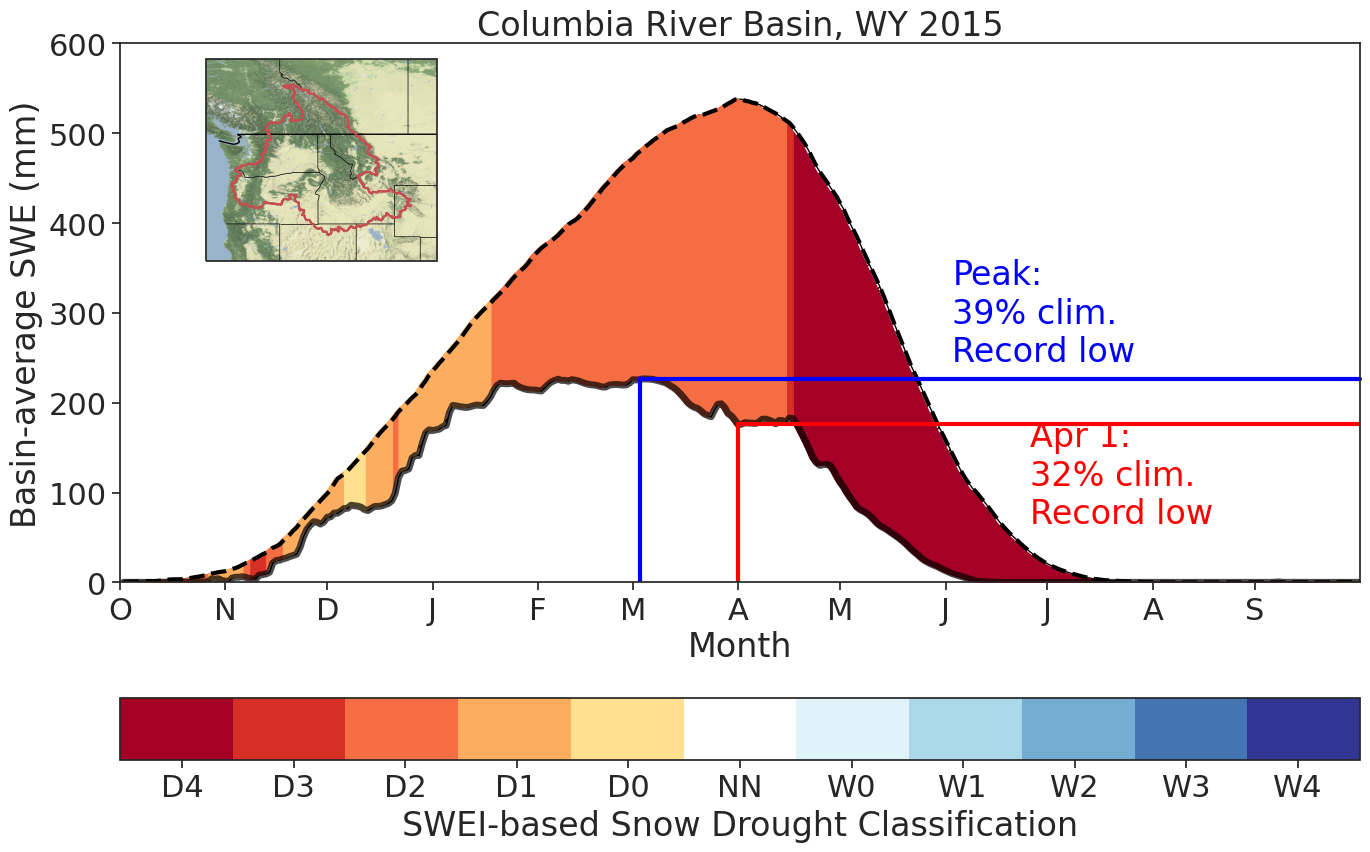

In [80]:
sns.set(font_scale=2,
        style="ticks")
from matplotlib import rcParams
rcParams.update({'figure.autolayout': False, "hatch.color": "black"})

fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

#################
### Figure 2a ###
#################

ax = plt.subplot(gs[0])

# plot climatological SWE
sns.lineplot(x=plot_basin_clim_df.index, y=plot_basin_clim_df["swe"].values, lw=3, color="black",legend=False, ax=ax)
for line in ax.lines:
    line.set_linestyle("--") # change linestyle
# plot WY 2015 SWE
sns.lineplot(x=year_plot_data['dowy'], y=year_plot_data["swe"].values, alpha=0.7, lw=5, color="black",legend=False, ax=ax)
ax.set_ylim(0,600)
ax.set_xlim(0,365)
ax.set_xticks([0, 31, 61, 92, 123, 151, 182, 212, 243, 273, 304, 334]) # add axis ticks for start of each month
ax.set_xticklabels(["O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A", "S"])
ax.set_xlabel("Month")
ax.set_ylabel(r"Basin-average SWE (mm)")
ax.title.set_text("Columbia River Basin, WY 2015")


# add imset showing where basin is in upper-left corner
stamen_terrain = cimgt.Stamen('terrain-background')
states_provinces = cartopy.feature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax_ins = inset_axes(ax, width="40%",height="50%",
                    loc="upper left",
                    bbox_to_anchor=(0,0.25,0.75,0.75),
                    bbox_transform=ax.transAxes,
                    axes_class=geoaxes.GeoAxes,
                    axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
bounds = grdc_basins[grdc_basins.RIVER_BASI==PLOT_BASIN].geometry.total_bounds
ax_ins.set_extent([bounds[0]-2, bounds[2]+2, bounds[1]-2,bounds[3]+2], crs=ccrs.PlateCarree())
ax_ins.add_image(stamen_terrain, 8)
grdc_basins[grdc_basins["RIVER_BASI"]==PLOT_BASIN].geometry.boundary.plot(ax=ax_ins, transform=ccrs.PlateCarree(),color="r") # add basin outline
ax_ins.add_feature(states_provinces, edgecolor='black',lw=0.5) # add state/province outlines
ax_ins.add_feature(cartopy.feature.BORDERS,edgecolor='black')

plt.savefig(os.path.join(fig_dir,'fig2_0.png'),bbox_inches='tight')
asp = ax.get_aspect()

# add text showing peak, date of peak, and 1 Apr values and percentiles
ax.axvline(x=182,ymin=0,ymax=swe_yr[182]/600,color="red",lw=3)
ax.axhline(swe_yr[182],xmin=182/365,xmax=1,color="red",lw=3)
ax.text(x=268,y=swe_yr[182]-110,s=f"Apr 1:\n{int(100*swe_yr[182]/plot_apr1_df['swe'].mean())}% clim.\nRecord low", color="red")

plt.savefig(os.path.join(fig_dir,'fig2_1.png'),bbox_inches='tight')


ax.axvline(x=swe_yr.argmax(),ymin=0,ymax=swe_yr.max()/600,color="blue",lw=3)
ax.axhline(y=swe_yr.max(),xmin=(swe_yr.argmax()+1)/365, xmax=1, clip_on=False,color="blue",lw=3)

ax.text(x=245,y=swe_yr.max()+20,s=f"Peak:\n{int(100*swe_yr.max()/plot_peak_df['swe'].mean())}% clim.\nRecord low", color="blue")

plt.savefig(os.path.join(fig_dir,'fig2_2.png'),bbox_inches='tight')

# get values to determine regions for shading/hatching
swe_clim = plot_basin_clim_df["swe"].values
swe_yr = np.pad(year_plot_data["swe"].values,(0,len(swe_clim)-len(year_plot_data['time'])),mode='constant',constant_values=0)


ax.fill_between(plot_basin_clim_df.index.values,swe_clim,swe_yr,where=swe_yr<swe_clim,facecolor="none",edgecolor="black",hatch="/") # hatch area where SWE < clim.
plt.savefig(os.path.join(fig_dir,'fig2_3.png'),bbox_inches='tight')


swei_sd = year_plot_data["SWEI_class"].values
swei_colors = [mpl.cm.RdYlBu(x) for x in np.linspace(0,1,len(swei_thresh)-1)]
swei_colors[5] = (1,1,1,1)

def consecutive(arr, n):
    # pad a with False at both sides for edge cases when array starts or ends with n
    d = np.diff(np.concatenate(([False], arr == n, [False])).astype(int))
    # subtract indices when value changes from False to True from indices where value changes from True to False
    return np.where(d==1)[0],np.where(d==-1)[0]

for d in np.arange(-5,6): # for each SWEI-based snow drought class...
    if d == 0:
        continue
    starts,ends = consecutive(swei_sd,d)
#     xs = np.where(swei_sd==d)[0] # ...get indices for dates where you're in each drought class
    if len(starts) == 0:
        continue    
    elif d < 0:
        for i in range(len(starts)):
            x_range = np.arange(starts[i]-1,ends[i])
#         for x_range in consecutive(xs):
            ax.fill_between(x_range,swe_clim[x_range],swe_yr[x_range], color=swei_colors[d+5]) # shade area between year curve and clim. curve according to drought class
    elif d > 0:
        for i in range(len(starts)):
            x_range = np.arange(starts[i]-1,ends[i])
#         for x_range in consecutive(xs):
            ax.fill_between(x_range,swe_yr[x_range],swe_clim[x_range], color=swei_colors[d+5]) # do the same for abnormally wet
            

plt.savefig(os.path.join(fig_dir,'fig2_4.png'),bbox_inches='tight')

# snotel_stns = pd.read_csv(os.path.join(root_dir,'SNOTEL','station_meta.csv'))
# snotel_stns['geometry'] = snotel_stns.apply(lambda x: Point(x['lon'],x[' lat']),axis=1)
# snotel_stns = gpd.GeoDataFrame(snotel_stns)
# snotel_stns = gpd.overlay(snotel_stns,grdc_basins)
# basin_stns = snotel_stns[snotel_stns['RIVER_BASI']==PLOT_BASIN]
# basin_stns.plot(ax=ax_ins)

# create colorbar for SWEI-based snow drought classifications
cmap = mpl.colors.ListedColormap(swei_colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.BoundaryNorm(np.linspace(0,100,len(swei_thresh)), len(swei_colors)))
sm.set_array([])
# cax = plt.subplot(gs[10,0])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal",use_gridspec=True)
cbar.ax.set_xlabel("SWEI-based Snow Drought Classification", rotation=0, labelpad=5)
# cbar.ax.set_xticklabels(mos)
tick_locs = np.linspace(5,95,len(swei_colors))
cbar.set_ticks(tick_locs)
swei_labels = ["D4", "D3", "D2", "D1", "D0", "NN", "W0", "W1", "W2", "W3", "W4"]
cbar.set_ticklabels(swei_labels)
ax.set_aspect(asp)
plt.savefig(os.path.join(fig_dir,'fig2_5.png'),bbox_inches='tight')


In [ ]:
def consecutive(data,val):
    val_ind = np.where(data==val)[0]
    

In [32]:
arr = np.array([0,0,1,1,2,2,2,1,1,0,0])

In [53]:
twos = np.where(arr==0)[0]

In [69]:
starts, ends = count_consecutive(arr,3)

In [70]:
starts

array([], dtype=int64)

In [61]:
np.where(count_consecutive(arr,0)

array([ 1,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0, -1])

In [56]:
np.where(np.diff(twos)==1)

(array([0, 2]),)

In [26]:
np.append(arr,[arr[-1]+1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])